  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [01:24<00:00,  1.69s/trial, best loss: -0.9740461740461741]
Hyperopt time: 84.55s, Best score: 0.9740
Sklearn time: 12.02s, Best score: 0.9744


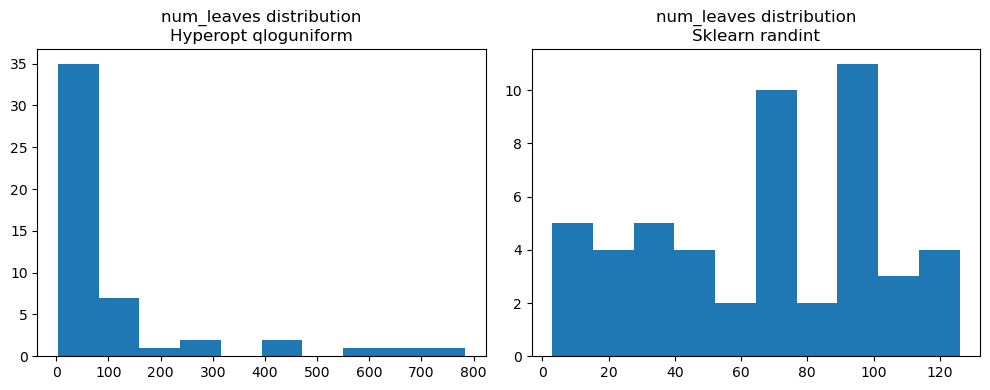

In [5]:
import numpy as np
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, rand
from scipy.stats import uniform, loguniform, randint
import time
import matplotlib.pyplot as plt

# make simple dataset 
X, y = make_classification(n_samples=10000, n_features=20, random_state=42)

# hyperopt setup
def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    model = LGBMClassifier(**params)
    score = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()
    return {'loss': -score, 'status': STATUS_OK}

space_hyperopt = {
    'num_leaves': hp.qloguniform('num_leaves', 1, 7, 1),
    'learning_rate': hp.loguniform('learning_rate', -7, 0)
}

# sklearn setup  
space_sklearn = {
    'num_leaves': randint(2, 128),
    'learning_rate': loguniform(np.exp(-7), np.exp(0))
}

# run experiments
n_trials = 50

# hyperopt
start = time.time()
trials = Trials()
best = fmin(objective, space_hyperopt, algo=tpe.suggest, max_evals=n_trials, trials=trials)
time_hyperopt = time.time() - start
scores_hyperopt = [-t['result']['loss'] for t in trials.trials]

# sklearn 
start = time.time()
search = RandomizedSearchCV(
    LGBMClassifier(),
    space_sklearn,
    n_iter=n_trials,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
search.fit(X, y)
time_sklearn = time.time() - start
scores_sklearn = search.cv_results_['mean_test_score']

print(f"Hyperopt time: {time_hyperopt:.2f}s, Best score: {max(scores_hyperopt):.4f}")
print(f"Sklearn time: {time_sklearn:.2f}s, Best score: {max(scores_sklearn):.4f}")

# plot distributions of num_leaves sampled
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist([t['misc']['vals']['num_leaves'][0] for t in trials.trials])
plt.title('num_leaves distribution\nHyperopt qloguniform')
plt.subplot(122)
plt.hist([p['num_leaves'] for p in search.cv_results_['params']])
plt.title('num_leaves distribution\nSklearn randint') 
plt.tight_layout()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# load data
df = pd.read_parquet('../scripts/benchmark_results_x100_negatives.parquet')

In [5]:
src = df.query("csc21_name == '2CXO J202403.8+335201'")

In [8]:
df.columns

Index(['csc21_name', 'csc21_ra', 'csc21_dec', 'csc21_errmaj', 'csc21_errmin',
       'csc21_errpa', 'hard_hs', 'hard_hm', 'hard_hm_lolim', 'hard_hm_hilim',
       'hard_ms', 'hard_ms_lolim', 'hard_ms_hilim', 'var_intra_prob_b',
       'var_intra_index_b', 'var_inter_prob_b', 'var_inter_index_b',
       'var_inter_sigma_b', 'extent_flag', 'pileup_flag', 'var_flag',
       'src_area_b', 'photflux_aper_b', 'photflux_aper_hilim_b',
       'photflux_aper_lolim_b', 'acis_time', 'min_theta_mean',
       'yangetal_gcs_class', 'yangetal_training_class', 'perezdiazetal_class',
       'gaia3_source_id', 'gaia3_ra', 'gaia3_dec', 'gaia3_era', 'gaia3_edec',
       'gaia3_epa', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
       'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_error',
       'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
  

In [12]:
print(src[['gaia3_source_id', 'separation', 'p_i', 'p_match_ind']].to_string())

            gaia3_source_id  separation           p_i  p_match_ind
409577  2056188586207165440   11.954130  0.000000e+00     0.053740
409578  2056188590502338816   14.733170  0.000000e+00     0.087570
409579  2056188590512831104    5.735496  0.000000e+00     0.419445
409580  2056188620566335360    1.417223  4.147917e-32     0.040342
409581  2056188620566337280    9.459555  0.000000e+00     0.064878
409582  2056188624872569088    0.029480  1.000000e+00     0.614657
409583  2056188693592046080   12.612470  0.000000e+00     0.283831


#### NGC 2516

In [2]:
df_all = pd.read_parquet('../data/nway_CSC21_GAIA3.parquet')

In [3]:
df_csc = pd.read_parquet('../data/csc_all.parquet')

In [4]:
# read vot to pandas ../data/all_stacks.vot
from astropy.io.votable import parse_single_table

# read vot to pandas
table = parse_single_table('../data/all_stacks.vot')

# recover column names
df_all_stacks = table.to_table().to_pandas()
df_all_stacks.columns = [col.name for col in table.fields]

In [7]:
df_csc.columns

Index(['name', 'ra', 'dec', 'hard_hs', 'hard_hm', 'hard_hm_lolim',
       'hard_hm_hilim', 'hard_ms', 'hard_ms_lolim', 'hard_ms_hilim',
       'var_intra_prob_b', 'var_intra_index_b', 'var_inter_prob_b',
       'var_inter_index_b', 'var_inter_sigma_b', 'extent_flag', 'pileup_flag',
       'var_flag', 'src_area_b', 'photflux_aper_b', 'photflux_aper_hilim_b',
       'photflux_aper_lolim_b', 'acis_time', 'min_theta_mean'],
      dtype='object')

In [8]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# center of the region
center = SkyCoord('07h58m06.5s -60d48m00s', frame='icrs')

# create SkyCoord objects for all sources
source_coords = SkyCoord(ra=df_all['CSC21_RA'].values * u.deg, dec=df_all['CSC21_Dec'].values * u.deg, frame='icrs')

# calculate separations
separations = source_coords.separation(center)

# filter the dataframe
df_all['separation_from_ngc2516'] = separations.to(u.arcmin)
sources_in_region = df_all[separations <= 30 * u.arcmin]
cscid_list = sources_in_region['CSC21_CSCID'].str.replace('_', ' ').str.strip().unique().tolist()
print(cscid_list)


['2CXO J075629.6-605413', '2CXO J075634.8-604802', '2CXO J075646.3-604857', '2CXO J075646.8-604322', '2CXO J075647.4-605651', '2CXO J075648.3-604630', '2CXO J075706.2-604337', '2CXO J075711.2-603308', '2CXO J075714.2-604052', '2CXO J075716.6-604711', '2CXO J075718.3-604816', '2CXO J075719.0-605627', '2CXO J075719.7-604846', '2CXO J075720.8-604402', '2CXO J075723.2-604938', '2CXO J075724.2-603947', '2CXO J075725.2-604647', '2CXO J075725.3-604458', '2CXO J075726.1-604540', '2CXO J075726.8-603947', '2CXO J075728.4-605129', '2CXO J075729.2-604608', '2CXO J075729.4-605210', '2CXO J075729.5-603706', '2CXO J075730.7-604720', '2CXO J075730.9-604832', '2CXO J075732.7-604111', '2CXO J075736.1-604812', '2CXO J075736.1-605024', '2CXO J075737.5-605435', '2CXO J075739.5-604413', '2CXO J075739.8-604639', '2CXO J075742.7-604420', '2CXO J075742.8-604540', '2CXO J075743.2-604509', '2CXO J075743.5-604945', '2CXO J075744.0-604727', '2CXO J075746.0-604550', '2CXO J075746.0-604839', '2CXO J075747.0-604239',

In [9]:
len(cscid_list)

153

In [22]:
matches = sources_in_region[sources_in_region['match_flag'] == 1]
ngc2516 = matches[['CSC21_CSCID', 'GAIA3_source_id', 'p_i', 'p_any', 'separation_from_ngc2516']]

ngc2516.to_csv('ngc2516.txt', sep='\t', index=False)


----

In [10]:
probabilities = ['p_i', 'p_match_ind', 'p_prod', 'p_match_any', 'p_match_norm', 'p_prod_any', 'p_prod_norm', 'p_prod_norm_renorm']

In [3]:
df['p_prod_norm_renorm'] = df.groupby('csc21_name').apply(lambda x: x['p_prod_norm']/np.sum(x['p_prod_norm'])).reset_index(drop=True)

/tmp/ipykernel_1348118/2896149701.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['p_prod_norm_renorm'] = df.groupby('csc21_name').apply(lambda x: x['p_prod_norm']/np.sum(x['p_prod_norm'])).reset_index(drop=True)


/tmp/ipykernel_3527987/910316586.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/vdiaz/.conda/envs/starsml/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


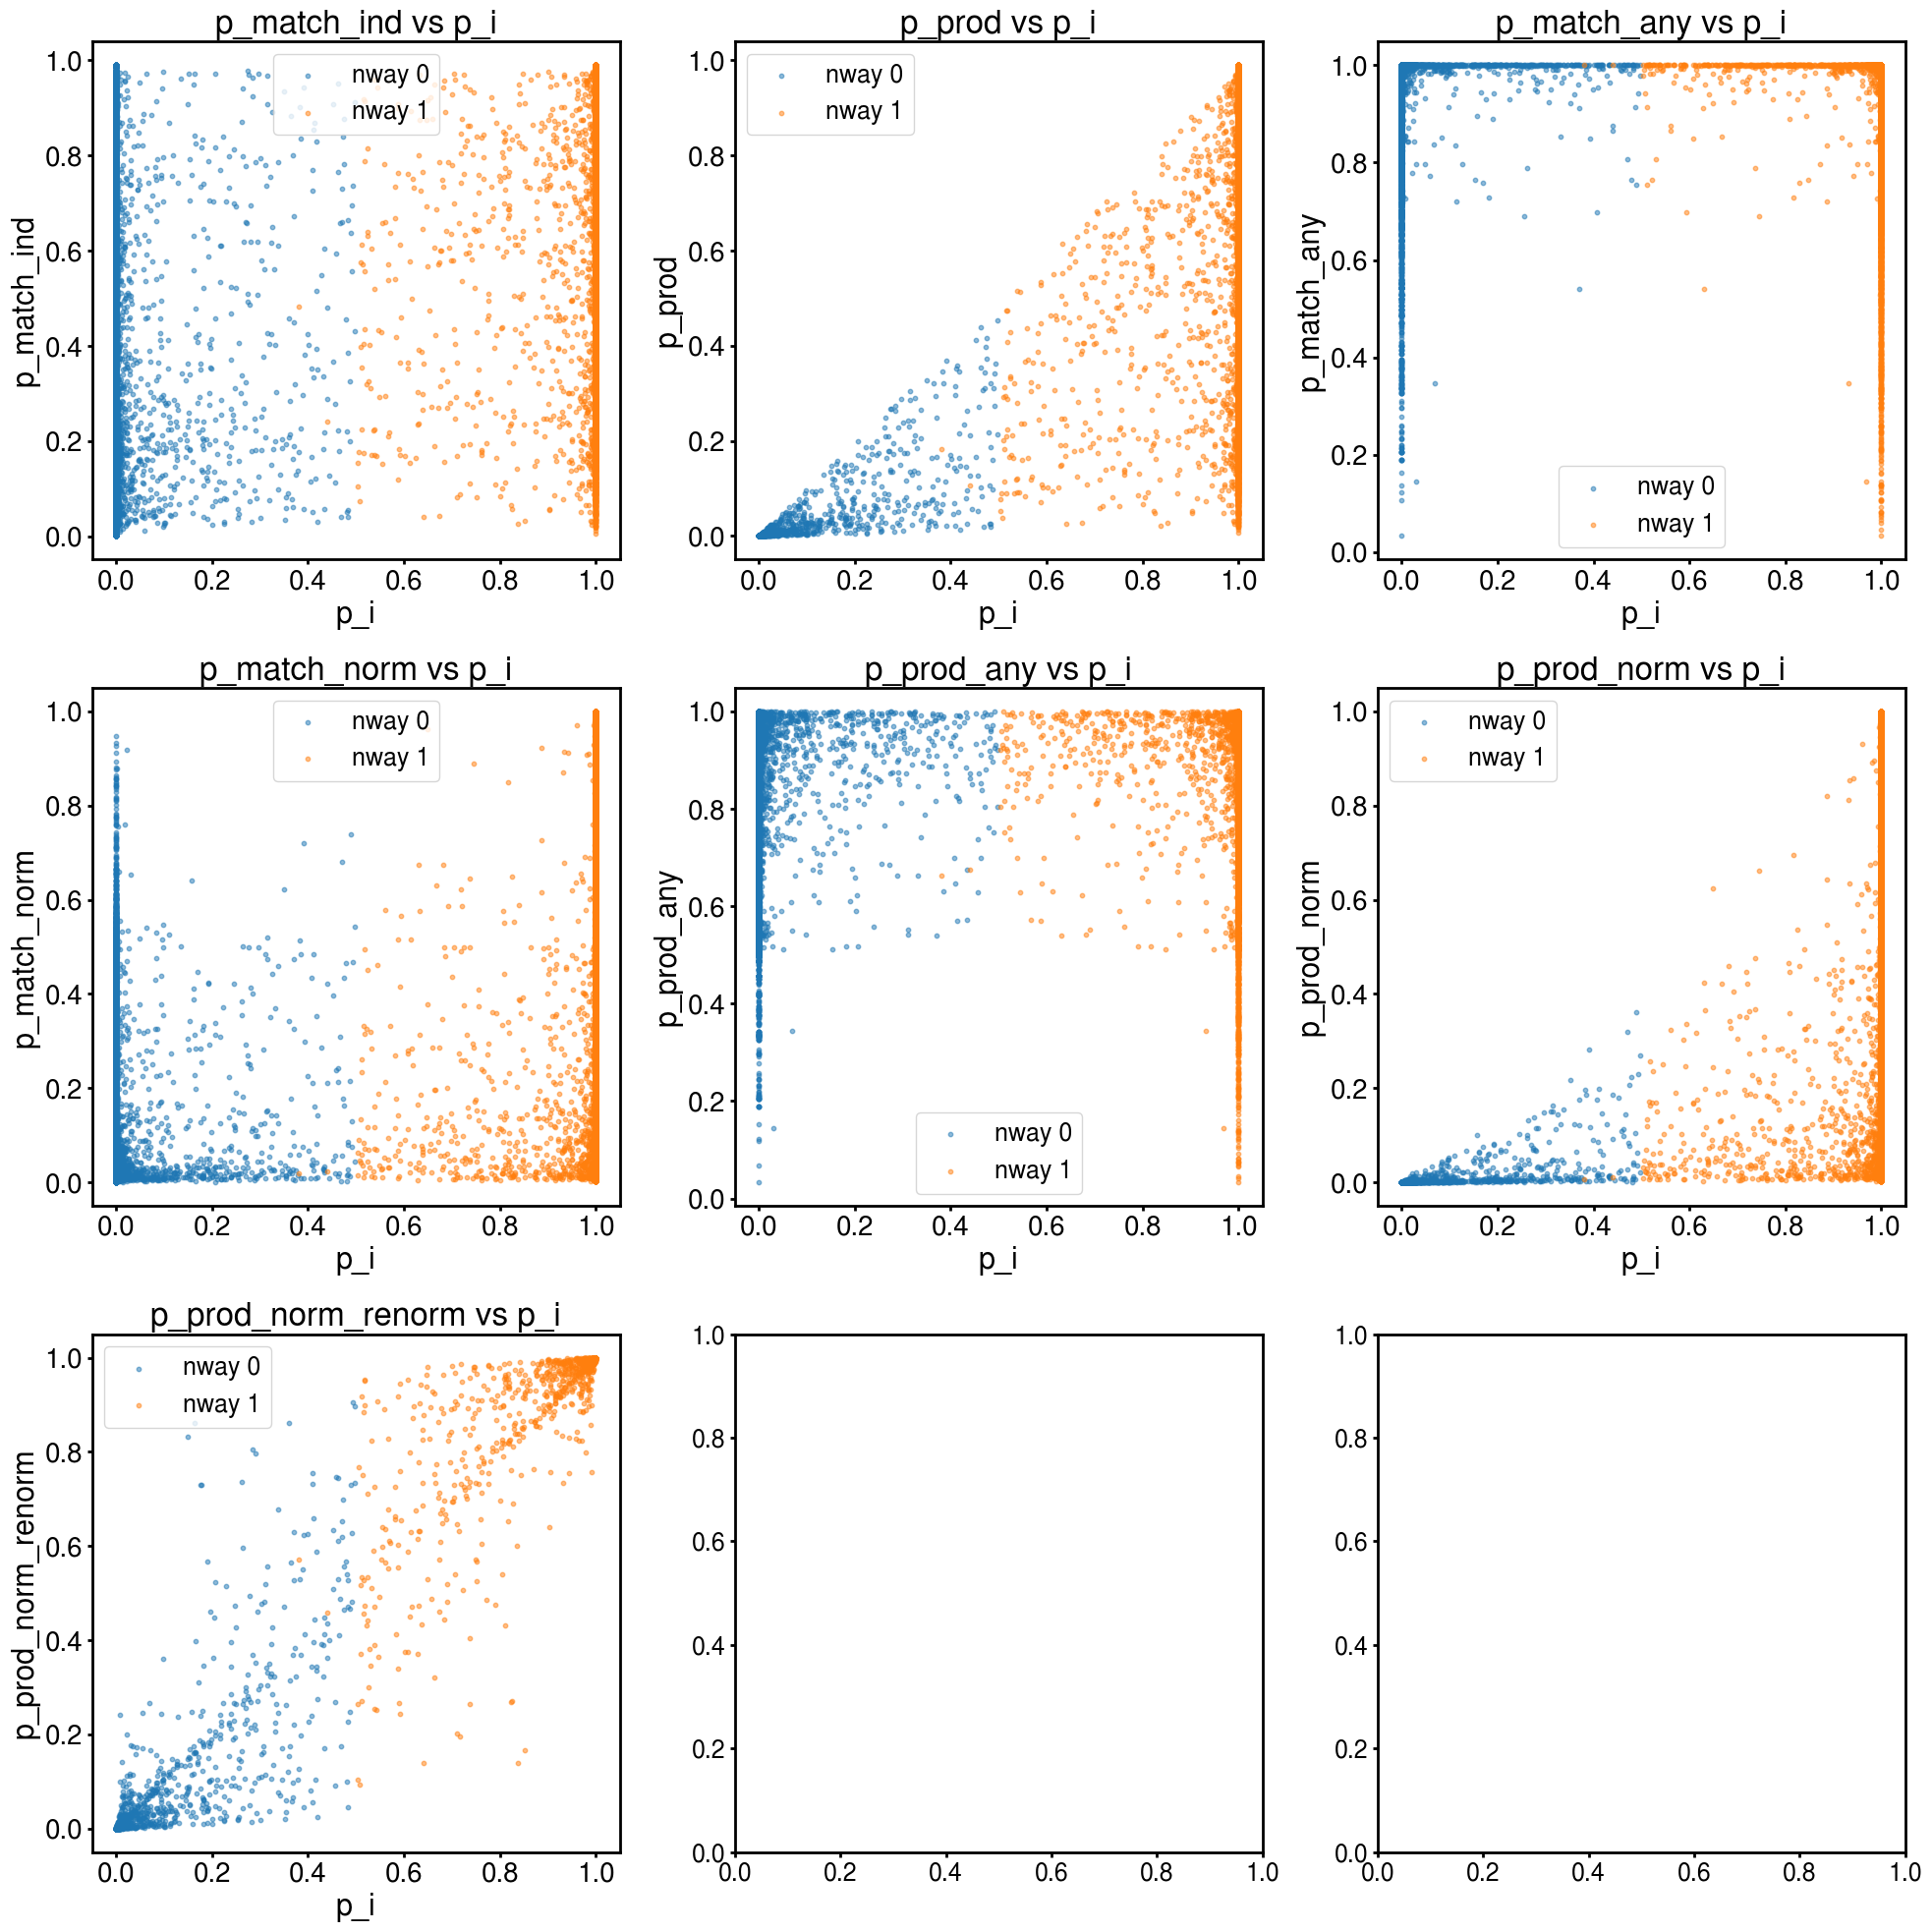

In [4]:
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 18  # Increased from 12
plt.rcParams['axes.linewidth'] = 2  # Increased from 1.5
plt.rcParams['xtick.major.width'] = 2  # Increased from 1.5
plt.rcParams['ytick.major.width'] = 2  # Increased from 1.5

# 1. scatter plots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))  # Increased figure size
axes = axes.ravel()
for i, prob in enumerate(probabilities[1:]):
    for label in [0, 1]:
        mask = df['benchmark_label'] == label
        axes[i].scatter(df.loc[mask, 'p_i'], df.loc[mask, prob], 
                        alpha=0.5, s=10, label=f'nway {label}')  # Smaller points
    axes[i].set_xlabel('p_i', fontsize=22)
    axes[i].set_ylabel(prob, fontsize=22)
    axes[i].set_title(f'{prob} vs p_i', fontsize=24)
    axes[i].tick_params(axis='both', which='major', labelsize=20)
    axes[i].legend(fontsize=18)
plt.tight_layout()
plt.show()

In [40]:
def calc_probability_missing(n_rows_per_source=102, test_fraction=0.2):
    # prob of one row not being in test set
    p_not_in_test = 1 - test_fraction
    
    # prob of ALL rows (for a c_id) not being in test set
    p_source_missing = p_not_in_test ** n_rows_per_source

    # prob of all rows of a source being in test set
    p_source_present = 1 - p_source_missing
    
    # prob for all sources
    p_all_present = (p_source_present) ** 32107 

    return p_all_present

p = calc_probability_missing()
print(f"Probability of all sources being present: {p:.10f}")

Probability of all sources being present: 0.9999958142


In [12]:
# 2. confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 50})
    plt.title(title, fontsize=26)
    plt.ylabel('NWAY label', fontsize=26)
    plt.xlabel('Predicted label', fontsize=26)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.show()
    
    # percentage
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', annot_kws={"size": 50})
    plt.title(title + ' (Percentage)', fontsize=26)
    plt.ylabel('NWAY label', fontsize=26)
    plt.xlabel('Predicted label', fontsize=26)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.show()

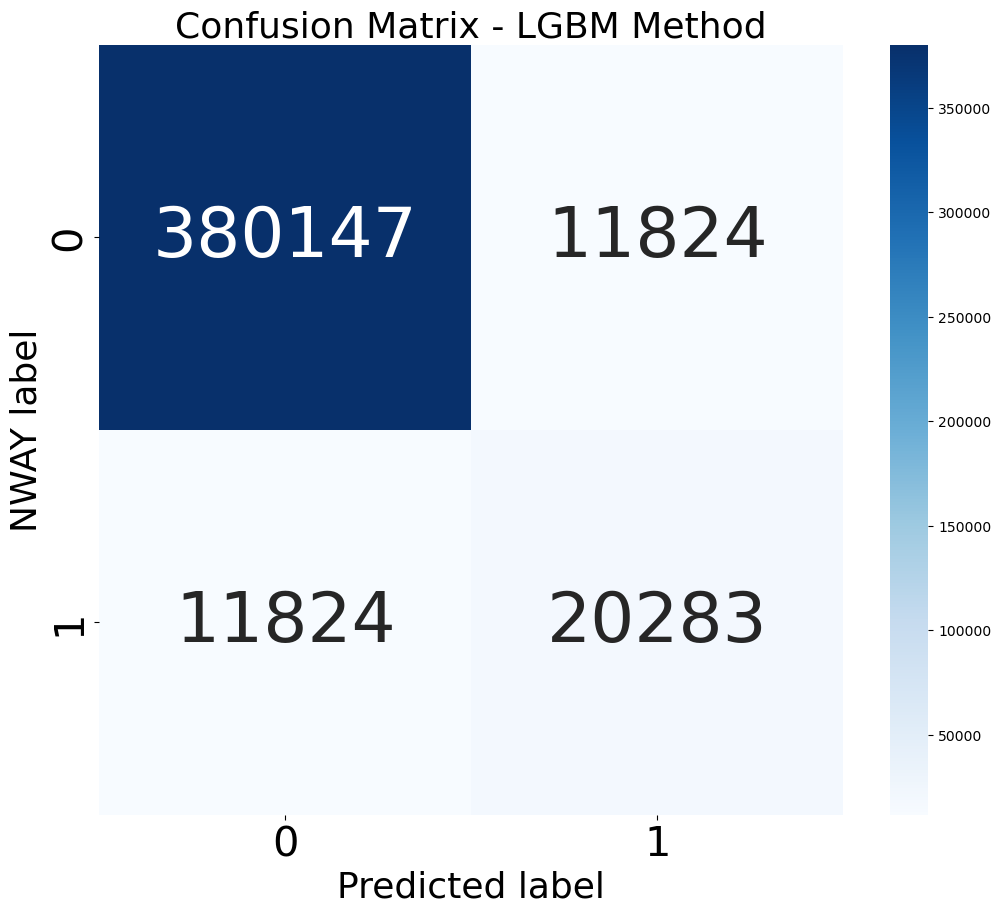

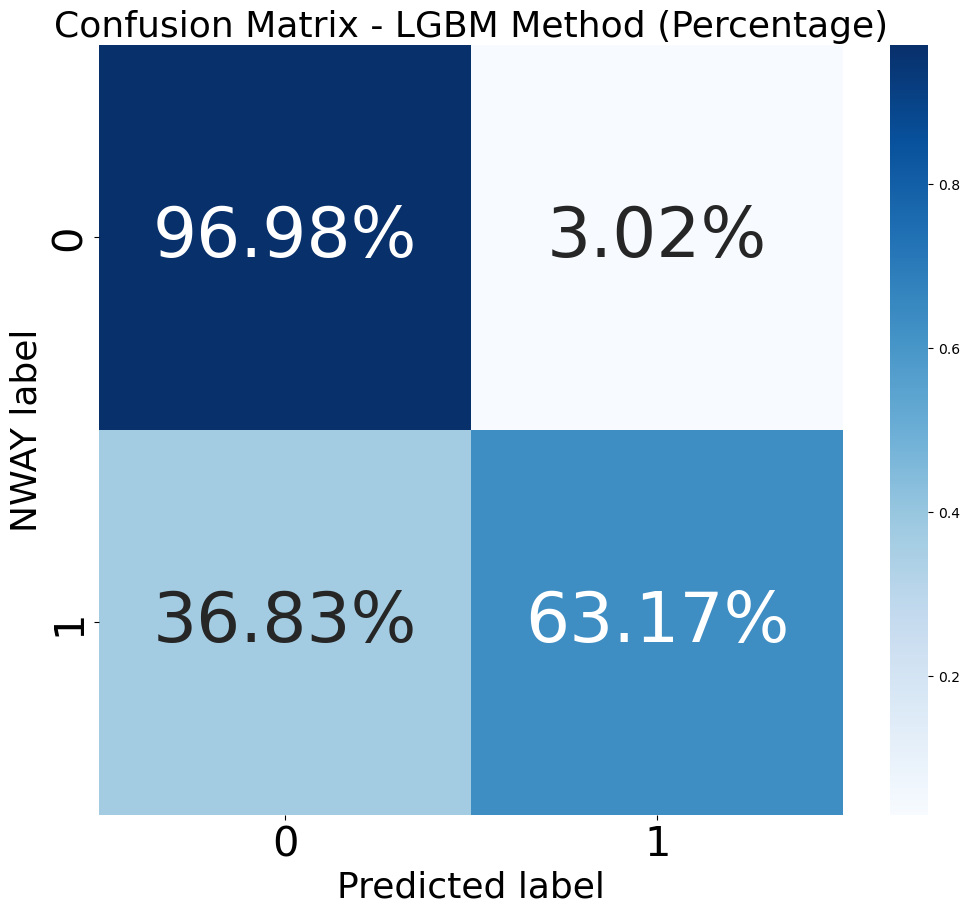

In [13]:

# function to get predictions based on max probability per group
def get_max_prob_predictions(df, prob_col):
    # identify max probability for each group
    idx = df.groupby('csc21_name')[prob_col].idxmax()
    
    # create a new column with 0s
    df['pred'] = 0
    
    # set 1 for the max probability in each group
    df.loc[idx, 'pred'] = 1
    
    return df['pred']

# get predictions for each method
bayesian_pred = get_max_prob_predictions(df, 'p_i')
lgbm_pred = get_max_prob_predictions(df, 'p_match_ind')
lgbm_norm_pred = get_max_prob_predictions(df, 'p_match_norm')
combined_pred = get_max_prob_predictions(df, 'p_prod')
combined_pred_simple = get_max_prob_predictions(df, 'p_prod_norm')

# true labels
true_labels = df['benchmark_label']

#plot_confusion_matrix(true_labels, bayesian_pred, 'Confusion Matrix - NWAY')
plot_confusion_matrix(true_labels, lgbm_pred, 'Confusion Matrix - LGBM Method')
#plot_confusion_matrix(true_labels, lgbm_norm_pred, 'Confusion Matrix - LGBM Method Normalized')
#plot_confusion_matrix(true_labels, combined_pred, 'Confusion Matrix - Product')
#plot_confusion_matrix(true_labels, combined_pred_simple, 'Confusion Matrix - Product with p_match normalized')

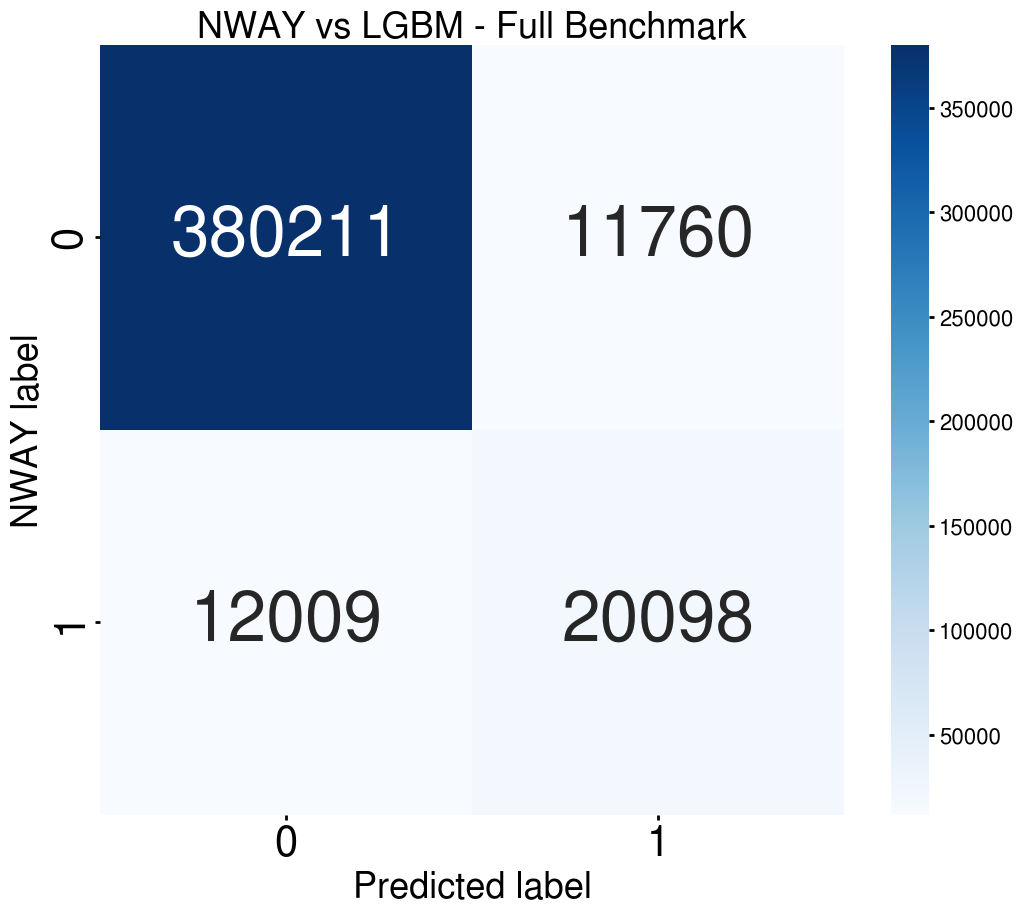

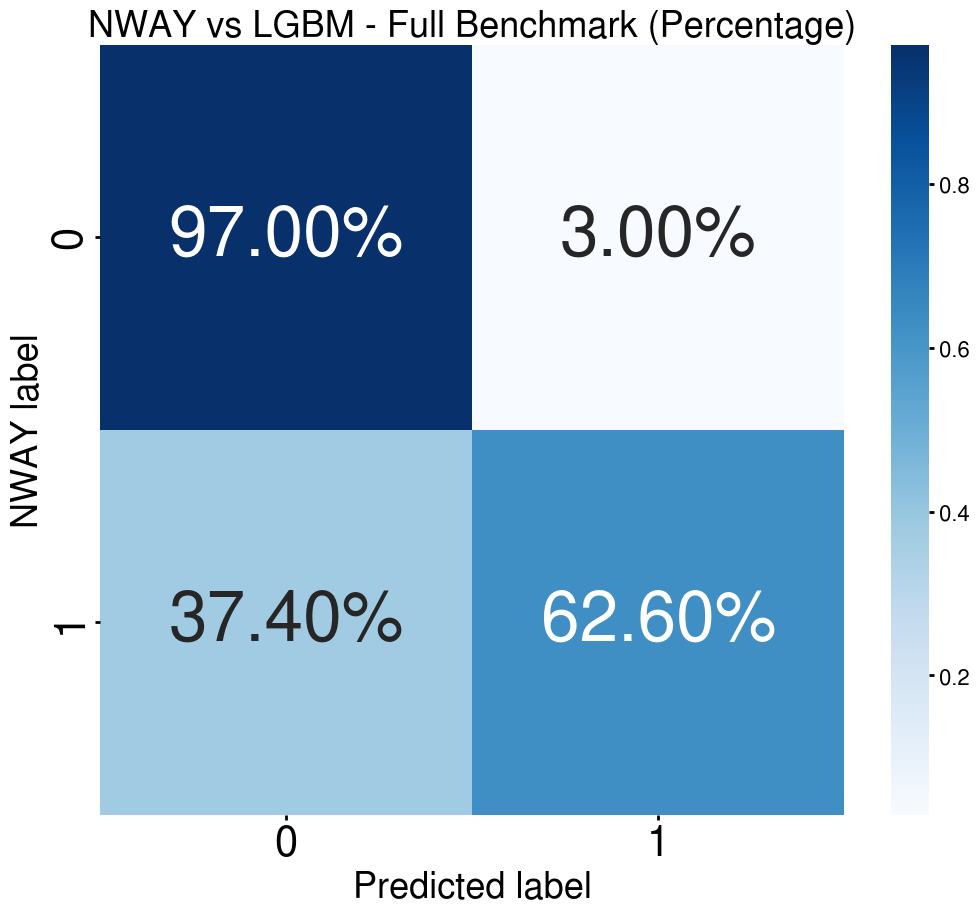

/tmp/ipykernel_3654980/305290173.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = 0


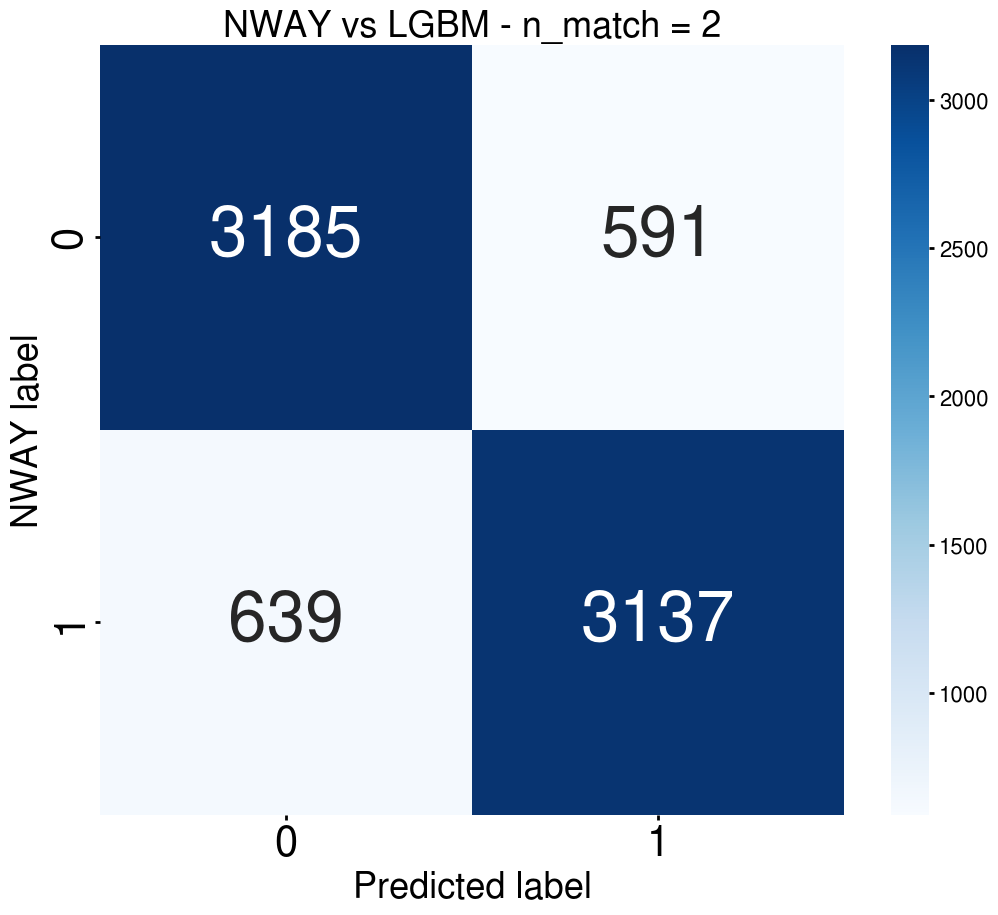

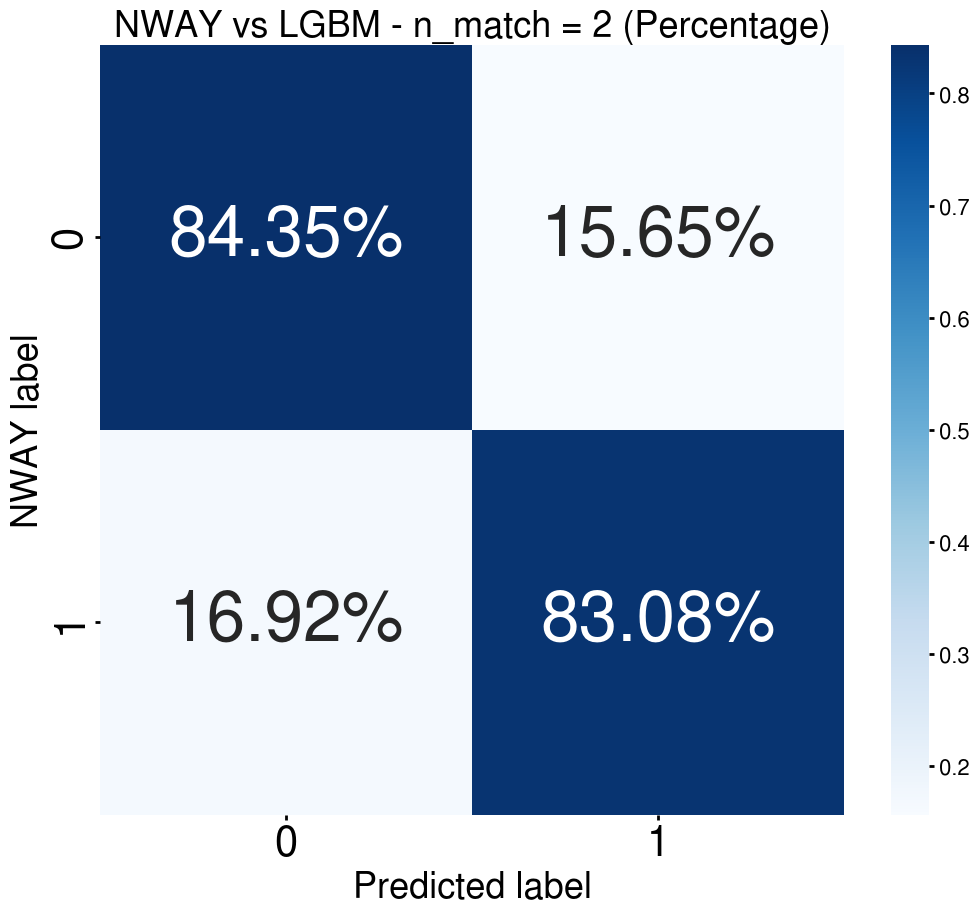

/tmp/ipykernel_3654980/305290173.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = 0


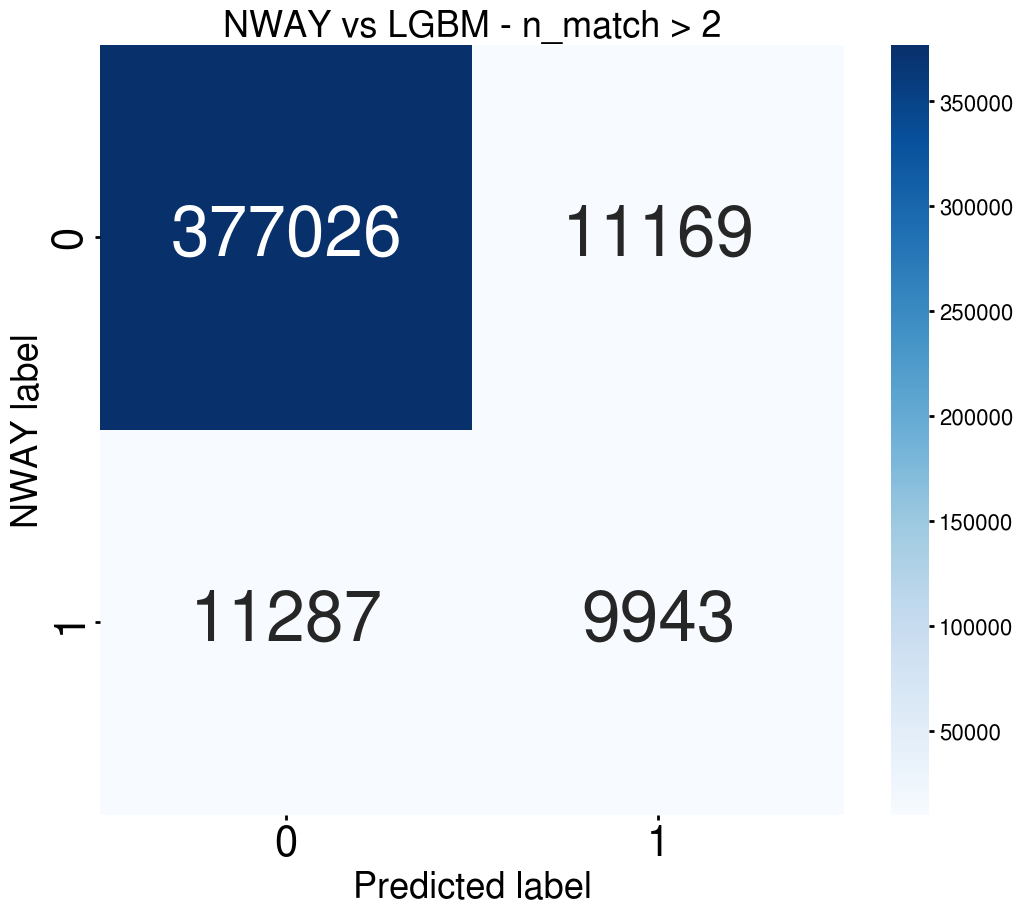

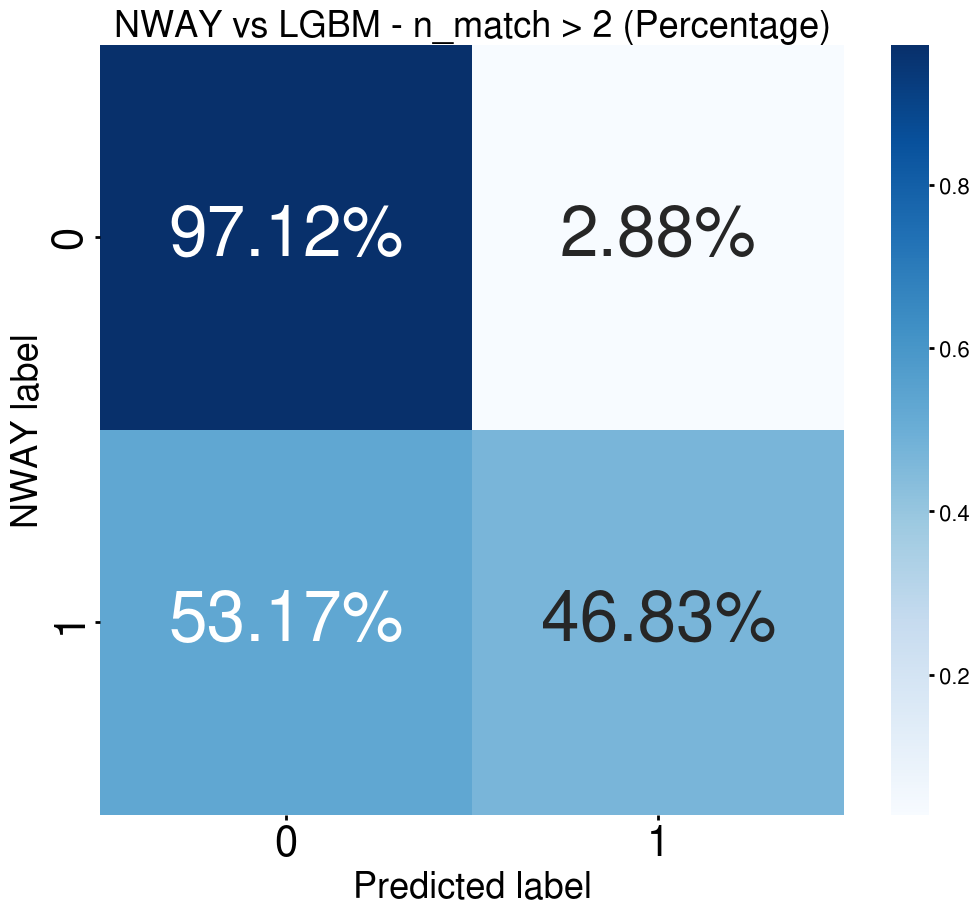

In [36]:
# Update the get_max_prob_predictions function to use the new threshold
def get_max_prob_predictions_with_threshold(df, prob_col, threshold=0.359):
    # identify max probability for each group
    idx = df.groupby('csc21_name')[prob_col].idxmax()
    
    # create a new column with 0s
    df['pred'] = 0
    
    # set 1 for the max probability in each group if it meets the threshold
    df.loc[idx, 'pred'] = (df.loc[idx, prob_col] >= threshold).astype(int)
    
    return df['pred']

# Get predictions using the new threshold
lgbm_pred_threshold = get_max_prob_predictions_with_threshold(df, 'p_match_ind', threshold=0.359)

# Define a function to plot confusion matrices for different subsets
def plot_confusion_matrices_for_subsets(df, true_labels, pred_labels, title_prefix):
    # Full benchmark
    plot_confusion_matrix(true_labels, pred_labels, f'{title_prefix} - Full Benchmark')
    
    # Nmatch = 2
    df_nmatch_2 = df[df['count'] == 2]
    true_labels_nmatch_2 = df_nmatch_2['benchmark_label']
    pred_labels_nmatch_2 = get_max_prob_predictions_with_threshold(df_nmatch_2, 'p_match_ind', threshold=0.359)
    plot_confusion_matrix(true_labels_nmatch_2, pred_labels_nmatch_2, f'{title_prefix} - n_match = 2')
    
    # Nmatch > 2
    df_nmatch_gt_2 = df[df['count'] > 2]
    true_labels_nmatch_gt_2 = df_nmatch_gt_2['benchmark_label']
    pred_labels_nmatch_gt_2 = get_max_prob_predictions_with_threshold(df_nmatch_gt_2, 'p_match_ind', threshold=0.359)
    plot_confusion_matrix(true_labels_nmatch_gt_2, pred_labels_nmatch_gt_2, f'{title_prefix} - n_match > 2')

bayesian_pred = get_max_prob_predictions(df, 'p_i')

# Plot confusion matrices for NWAY vs RF with the new threshold
plot_confusion_matrices_for_subsets(df, bayesian_pred, lgbm_pred_threshold, 'NWAY vs LGBM')

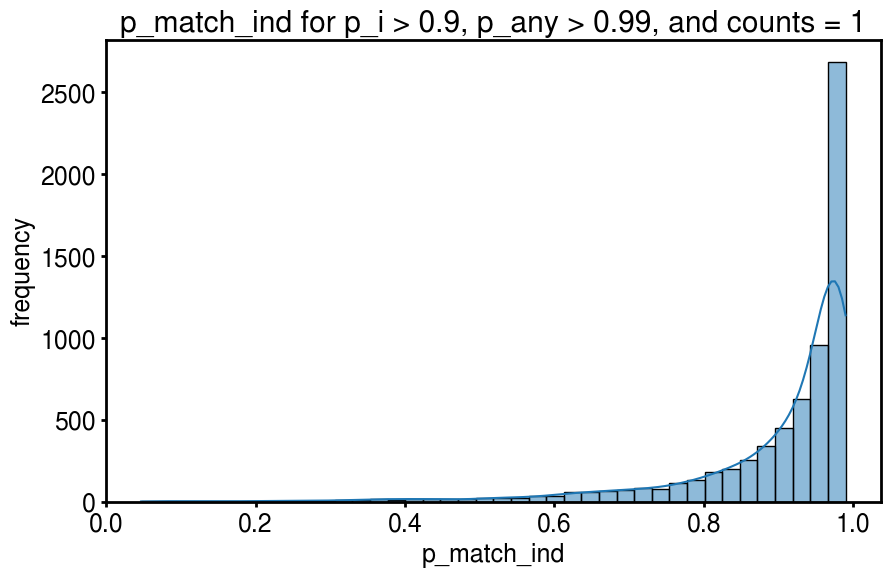

In [25]:
# set plot parameters
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 18  
plt.rcParams['axes.linewidth'] = 2  
plt.rcParams['xtick.major.width'] = 2  
plt.rcParams['ytick.major.width'] = 2 

# filter dataframe
filtered_df = df[(df['p_i'] > 0.9) & (df['p_any'] > 0.99) & (df['count'] == 1)]

# plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['p_match_ind'], bins=40, kde=True)
plt.title('p_match_ind for p_i > 0.9, p_any > 0.99, and counts = 1')
plt.xlabel('p_match_ind')
plt.ylabel('frequency')
plt.show()


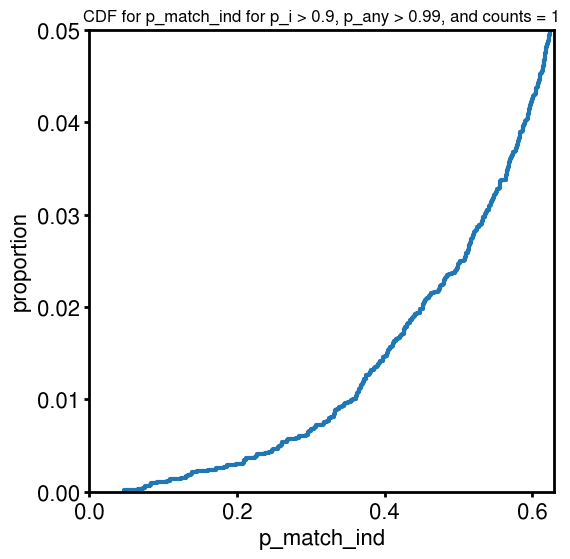

Interpolated value at y=0.01: 0.3597756526963723


In [29]:
# set plot parameters
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 16 
plt.rcParams['axes.linewidth'] = 2  
plt.rcParams['xtick.major.width'] = 2  
plt.rcParams['ytick.major.width'] = 2 

# filter dataframe
filtered_df = df[(df['p_i'] > 0.9) & (df['p_any'] > 0.99) & (df['count'] == 1)]

# plot cdf
plt.figure(figsize=(6, 6))
sns.ecdfplot(filtered_df['p_match_ind'], linewidth=3)
plt.title('CDF for p_match_ind for p_i > 0.9, p_any > 0.99, and counts = 1', fontsize=12)
plt.xlabel('p_match_ind')
plt.ylabel('proportion')
plt.xlim(0, 0.63)
plt.ylim(0, 0.05)
plt.show()

# Interpolate the value at y=0.01
y_value = 0.01
x_value = np.interp(y_value, np.linspace(0, 1, len(filtered_df['p_match_ind'])), np.sort(filtered_df['p_match_ind']))
#x_value = np.percentile(filtered_df['p_match_ind'], 1)
print(f"Interpolated value at y={y_value}: {x_value}")

In [28]:
filtered_df.csc21_name.unique().shape[0]

6662

In [27]:
len(filtered_df.csc21_name.unique())*0.01

66.62

In [97]:
np.percentile(filtered_df['p_match_ind'], 5)

0.624814465356237

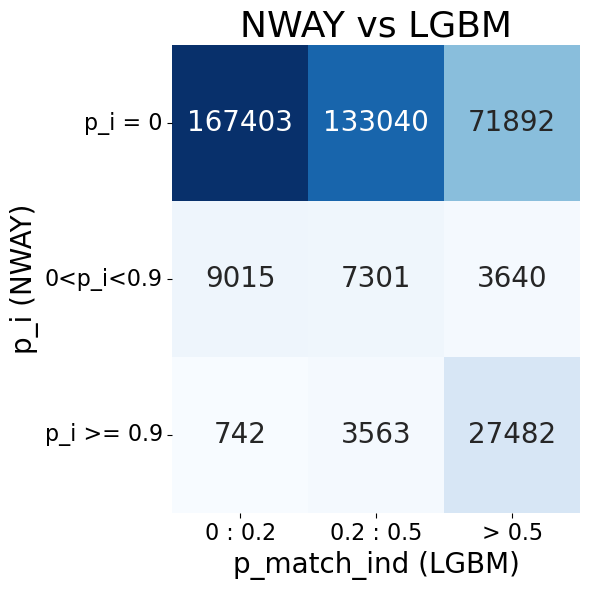

In [13]:
def plot_custom_probability_matrix(df, title):
    # Create bins for P_i (NWAY)
    df['P_i_bins'] = pd.cut(df['p_i'], bins=[-np.inf, 0, 0.9, np.inf], labels=['p_i = 0', '0<p_i<0.9', 'p_i >= 0.9'])
    
    # Create bins for P_match_ind (LGBM)
    df['P_match_bins'] = pd.cut(df['p_match_ind'], bins=[-np.inf, 0.2, 0.5, np.inf], labels=['0 : 0.2', '0.2 : 0.5', '> 0.5'])
    
    # Create the contingency table
    contingency = pd.crosstab(df['P_i_bins'], df['P_match_bins'], normalize=False)
    
    # Create the plot
    plt.figure(figsize=(6, 6))
    sns.heatmap(contingency, annot=True, cmap='Blues', cbar=False, fmt='d', annot_kws={"fontsize": 20})
    
    # Set labels and title
    plt.yticks(rotation=0, va='center', fontsize=16)
    plt.xticks(rotation=0, ha='center', fontsize=16)
    plt.ylabel('p_i (NWAY)', fontsize=20)
    plt.xlabel('p_match_ind (LGBM)', fontsize=20)
    plt.title(title, fontsize=26)
    
    plt.tight_layout()
    plt.show()

# Usage
plot_custom_probability_matrix(df, 'NWAY vs LGBM')

In [20]:
benchmark_original.csc21_name.unique().shape[0]

32107

In [21]:
benchmark_original = pd.read_parquet('../out_data/full_negatives/df_pos_0-3_X1000.parquet')

In [22]:
benchmark_original.csc21_name.unique().shape[0]

32107

In [32]:
from sklearn.metrics import recall_score

def create_benchmark_labels(df, prob_col, criteria):
    benchmarks = {}
    for name, condition in criteria.items():
        if isinstance(condition, tuple):
            p_i, p_any = condition
            benchmark = ((df[prob_col] > p_i) & (df['p_any'] > p_any)).astype(int)
        else:
            benchmark = (df[prob_col] > condition).astype(int)
        benchmarks[name] = benchmark
    
    return benchmarks
def calculate_recalls(benchmarks, lgbm_pred):
    results = {}
    for name, benchmark in benchmarks.items():
        #print(benchmark)
        recall = recall_score(benchmark, lgbm_pred)
        tp = (benchmark & lgbm_pred).sum()
        fn = (benchmark & ~lgbm_pred).sum()
        results[name] = {
            "Recall": recall,
            "TP": tp,
            "FN": fn,
            "Relative Recall": tp / (tp + fn) if (tp + fn) > 0 else 0
        }
    return results

# define criteria for benchmarks
criteria = {
    "p_i > 0.6": 0.6,
    "p_i > 0.8": 0.8,
    "p_i > 0.9": 0.9,
    "p_i > 0.9 and p_any > 0.9": (0.9, 0.9),
    "p_i > 0.95 and p_any > 0.95": (0.95, 0.95),
    "p_i > 0.99 and p_any > 0.95": (0.99, 0.95),
    "p_i > 0.99 and p_any > 0.99": (0.99, 0.99),
    "p_i > 0.6 and p_any > 0.99": (0.6, 0.99)
}

# create benchmarks
benchmarks = create_benchmark_labels(df[df.count == 1], 'p_i', criteria)

# calculate recalls
results = calculate_recalls(benchmarks, lgbm_pred)

# create results table
table_data = [
    [name, data["TP"], data["FN"], 
     f"{data['Recall']:.4f}", 
     f"{data['Relative Recall']:.2%}"]
    for name, data in results.items()
]

table = pd.DataFrame(table_data, 
                     columns=["Benchmark", "TP", "FN", "Recall", "Relative Recall"])
print(table.to_string(index=False))

KeyError: False

In [13]:
thresholds = np.concatenate([np.concatenate([np.arange(0.5, 0.9, 0.1, dtype=float), np.arange(0.9, 1, 0.01, dtype=float)]), np.arange(0.9, 1, 0.01, dtype=float)])

# combinations
criteria = {}
for p_i in thresholds:
    for p_any in thresholds:
        criteria[f"p_i >= {p_i:.2f} and p_any >= {p_any:.2f}"] = (p_i, p_any)

benchmarks = create_benchmark_labels(df, 'p_i', criteria)
results = calculate_recalls(benchmarks, lgbm_pred)

# plotting data
plot_data = []
for name, data in results.items():
    p_i, p_any = name.split('and')
    p_i = float(p_i.split('>=')[1].strip())
    p_any = float(p_any.split('>=')[1].strip())
    plot_data.append({
        'p_i': p_i,
        'p_any': p_any,
        'Relative Recall': data['Relative Recall']
    })

df_plot = pd.DataFrame(plot_data)

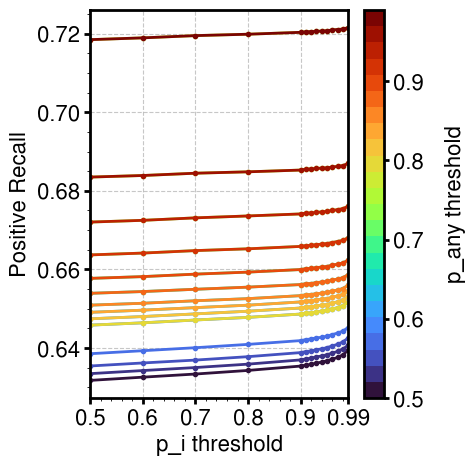

In [48]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 18  
plt.rcParams['axes.linewidth'] = 2  
plt.rcParams['xtick.major.width'] = 2  
plt.rcParams['ytick.major.width'] = 2 

# Create line plot
fig, ax = plt.subplots(figsize=(5, 5))

# Create a custom colormap
colors = plt.cm.turbo(np.linspace(0, 1, len(thresholds)))
custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=len(thresholds))

# Plot lines with color gradient
for i, p_any in enumerate(thresholds):
    subset = df_plot[df_plot['p_any'] == round(p_any, 2)]
    ax.plot(subset['p_i'], subset['Relative Recall'], marker='o', 
            color=custom_cmap(i / len(thresholds)), 
            linewidth=2, markersize=3)
ax.tick_params(axis='both', which='major', labelsize=16, length=4)
ax.minorticks_on()
ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

ax.set_xlabel('p_i threshold', fontsize=16)
ax.set_ylabel('Positive Recall', fontsize=16)
#ax.set_title('Positive Recall vs p_i Threshold for Different p_any Values', fontsize=18)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=min(thresholds), vmax=max(thresholds)))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('p_any threshold', fontsize=16, labelpad=15)
cbar.ax.tick_params(labelsize=16) 

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlim(min(thresholds), max(thresholds))

plt.tight_layout()
plt.savefig('figures/relative_recall_lineplot.png', dpi=300, bbox_inches='tight')
plt.show()

#### Distributions of model probabilities for nway=1

Text(0.5, 1.0, 'Distribution of p_match_ind for nway=1')

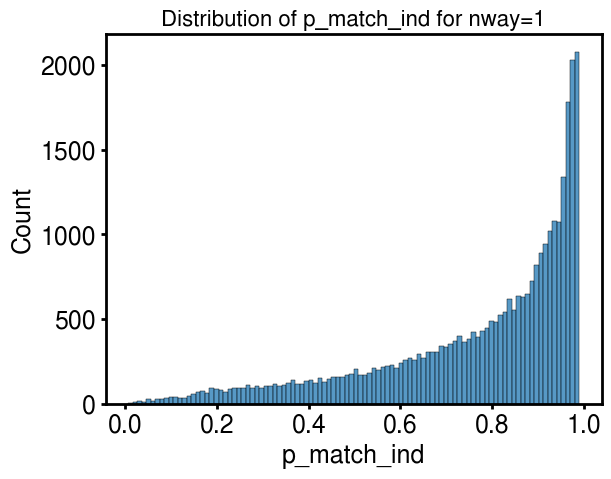

In [67]:
sns.histplot(data=df[df.benchmark_label == 1], x='p_match_ind', bins=100)
plt.title('Distribution of p_match_ind for nway=1', size=16)

#### Distribution of separations for nway = 1

<Axes: xlabel='separation', ylabel='Count'>

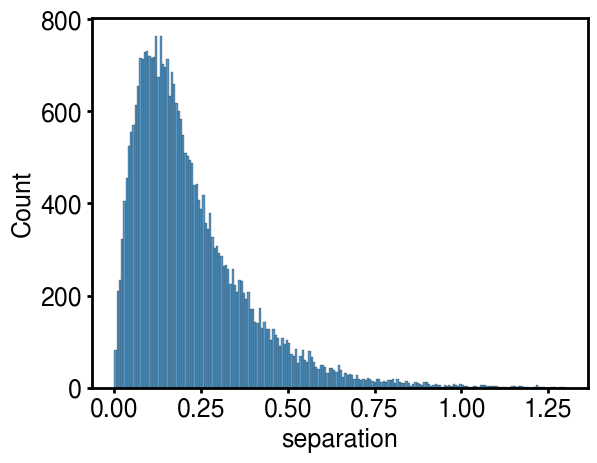

In [31]:
sns.histplot(data=df[df.benchmark_label == 1], x='separation', bins=200)

#### $\Delta p\_match\_ind $
---


In [ ]:
def calculate_delta_p_match_ind(group):
    max_p_match_ind = group['p_match_ind'].max()
    delta = max_p_match_ind - group['p_match_ind']
    return delta.where(delta != 0, np.nan)

# Calculate lgbm_pred
df['lgbm_pred'] = get_max_prob_predictions(df, 'p_match_ind')

# Group by X-ray source and calculate Δp_match_ind
df['delta_p_match_ind'] = df.groupby('csc21_name').apply(calculate_delta_p_match_ind).reset_index(level=0, drop=True)

# Calculate N for each X-ray source
df['N'] = df['count']



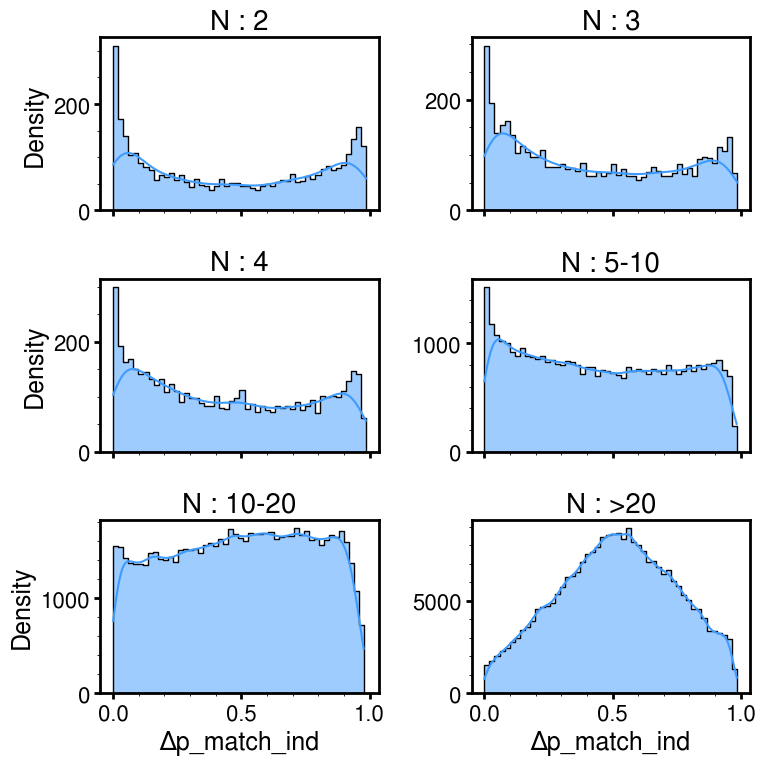


Summary statistics for N:2:
count    3769.000000
mean        0.464615
std         0.339721
min         0.000028
25%         0.122099
50%         0.448514
75%         0.803491
max         0.986422
Name: delta_p_match_ind, dtype: float64

Summary statistics for N:3:
count    4616.000000
mean        0.432220
std         0.317280
min         0.000024
25%         0.130701
50%         0.387978
75%         0.727064
max         0.986802
Name: delta_p_match_ind, dtype: float64

Summary statistics for N:4:
count    5401.000000
mean        0.439236
std         0.310053
min         0.000004
25%         0.151425
50%         0.405227
75%         0.724890
max         0.985677
Name: delta_p_match_ind, dtype: float64

Summary statistics for N:5-10:
count    40660.000000
mean         0.454570
std          0.290926
min          0.000008
25%          0.193016
50%          0.439391
75%          0.711270
max          0.984046
Name: delta_p_match_ind, dtype: float64

Summary statistics for N:10-20:
count   

In [52]:
# Set up the plot
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

fig, axs = plt.subplots(3, 2, figsize=(8, 8), sharex=True, sharey=False)
axs = axs.ravel()

n_values = [2, 3, 4, '5-10', '10-20', '>20']

for i, n in enumerate(n_values):
    if n == '>20':
        data = df[df['N'] > 20]['delta_p_match_ind']
    elif n == '5-10':
        data = df[(df['N'] >= 5) & (df['N'] <= 10)]['delta_p_match_ind']
    elif n == '10-20':
        data = df[(df['N'] >= 10) & (df['N'] <= 20)]['delta_p_match_ind']
    else:
        data = df[df['N'] == n]['delta_p_match_ind']

    # color palette: Wes Anderson Asteroid City
    
    sns.histplot(data, kde=True, ax=axs[i], color=plt.cm.turbo(0.2), edgecolor='black', bins=50, element="step", fill=True)
    axs[i].set_title(f'N : {n}', fontsize=20)
    axs[i].set_xlabel('Δp_match_ind' if i in [4, 5] else '', fontsize=18)
    axs[i].set_ylabel('Density' if i in [0, 2, 4] else '', fontsize=18)
    axs[i].tick_params(axis='both', which='major', labelsize=16, length=4)
    axs[i].minorticks_on()
    #axs[i].set_yticks(np.arange(min(data), max(data)+1, 1.0))


plt.tight_layout()
plt.savefig('figures/delta_p_match_ind_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
for n in n_values:
    if n == '>20':
        data = df[df['N'] > 20]['delta_p_match_ind']
    elif n == '5-10':
        data = df[(df['N'] >= 5) & (df['N'] <= 10)]['delta_p_match_ind']
    elif n == '10-20':
        data = df[(df['N'] >= 10) & (df['N'] <= 20)]['delta_p_match_ind']
    else:
        data = df[df['N'] == n]['delta_p_match_ind']
    
    print(f"\nSummary statistics for N:{n}:")
    print(data.describe())


/home/vdiaz/.conda/envs/starsml/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


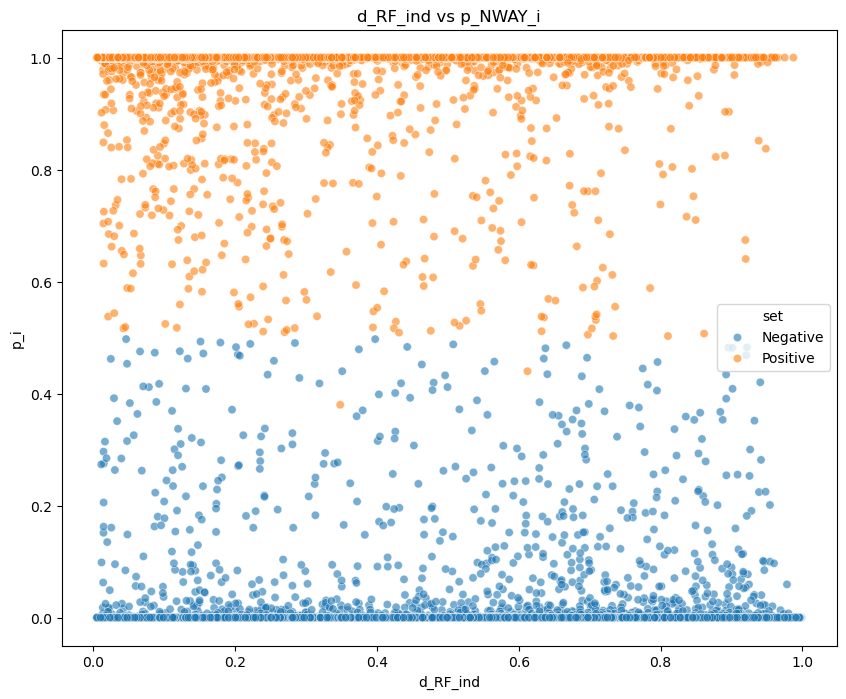

In [11]:
# Calculate d_RF_ind
df['d_LGBM_ind'] = (1 - df['p_match_ind']) / (1 + df['p_match_ind'])

# Create 'set' column
df['set'] = np.where(df['benchmark_label'] == 1, 'Positive',
                     np.where(df['benchmark_label'] == 0, 'Negative', 'Benchmark'))

# Scatter plot of d_RF_ind vs p_NWAY_i
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='d_RF_ind', y='p_i', hue='set', alpha=0.6)
plt.title('d_RF_ind vs p_NWAY_i')
plt.show()

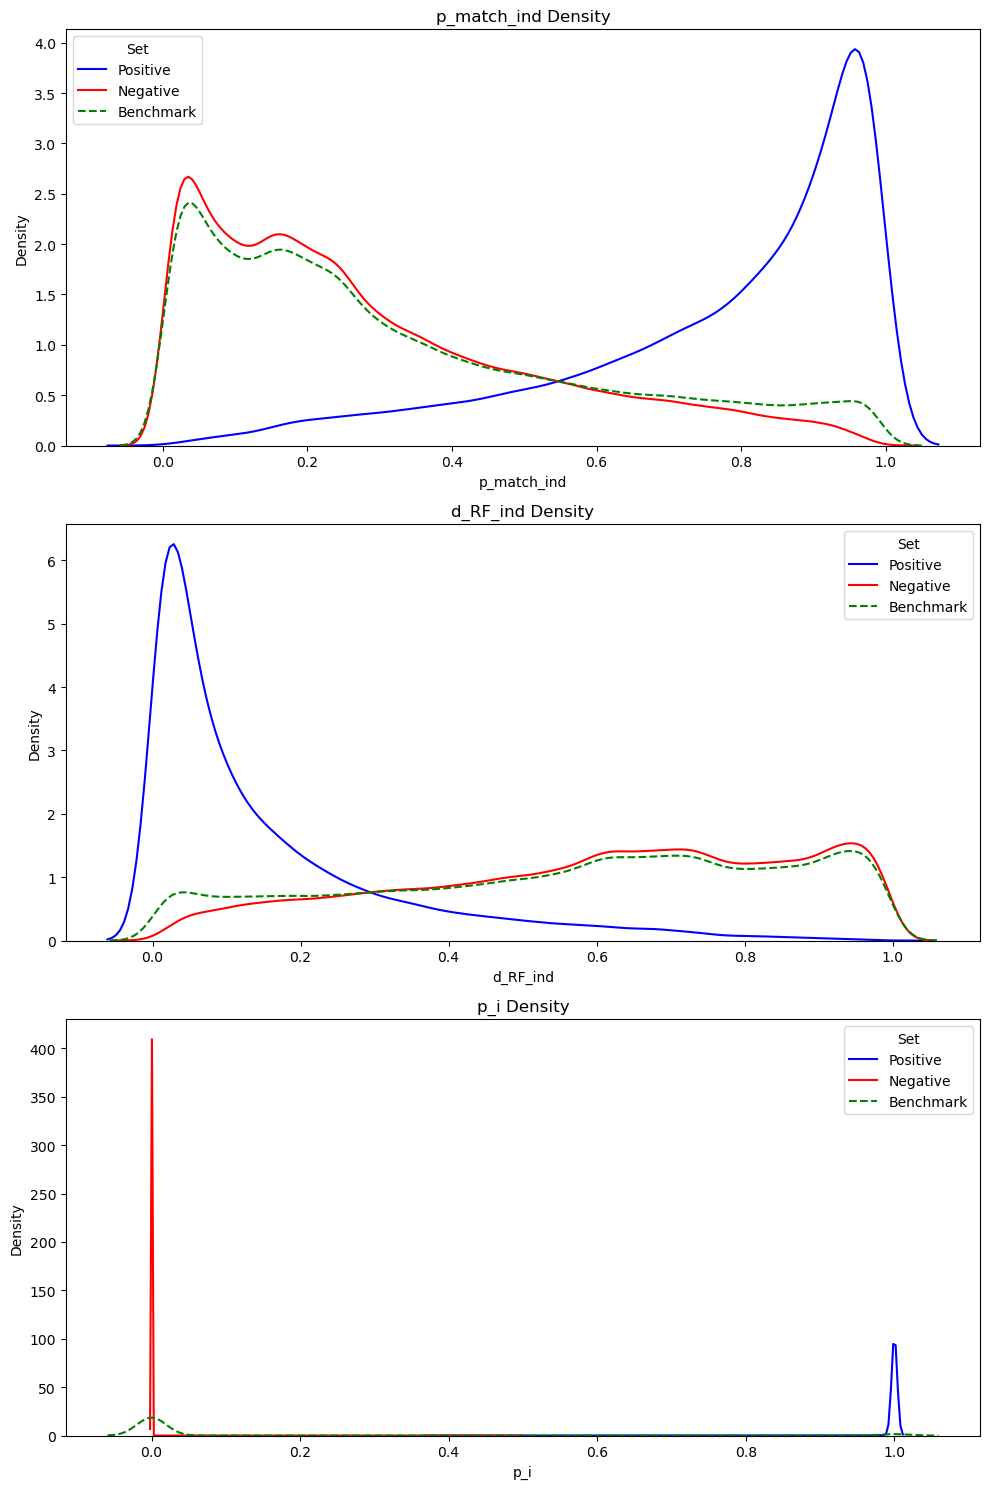

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
colors = {'Positive': 'blue', 'Negative': 'red', 'Benchmark': 'green'}
sets = ['Positive', 'Negative', 'Benchmark']

for i, col in enumerate(['p_match_ind', 'd_RF_ind', 'p_i']):
    for set_name in sets:
        if set_name == 'Benchmark':
            sns.kdeplot(data=df, x=col, ax=axs[i], color=colors[set_name], 
                        linestyle='--', label=set_name)
        else:
            sns.kdeplot(data=df[df['set'] == set_name], x=col, ax=axs[i], 
                        color=colors[set_name], label=set_name)
    
    axs[i].set_title(f'{col} Density')
    axs[i].legend(title='Set')

plt.tight_layout()
plt.show()



In [ ]:
def calculate_refined_contrast_index(group):
    positive_prob = group[group['lgbm_label'] == 1]['p_match_ind'].iloc[0]
    negative_probs = group[group['lgbm_label'] == 0]['p_match_ind']
    
    if len(negative_probs) == 0:
        return np.nan  # If no negatives, return NaN
    
    avg_negative_prob = negative_probs.mean()
    
    # use absolute difference
    contrast = (positive_prob - avg_negative_prob) / (positive_prob + avg_negative_prob)
    
    # normalize by the maximum possible difference (1 in this case)
    return contrast

def plot_refined_contrast_index(data):
    contrast_indices = data.groupby('csc21_name').apply(calculate_refined_contrast_index)
    
    # remove NaN values for plotting and statistics
    valid_indices = contrast_indices.dropna()
    
    plt.figure(figsize=(12, 6))
    plt.hist(valid_indices, bins=50, edgecolor='black')
    plt.title('Distribution of contrast indices')
    plt.xlabel('Contrast Index')
    plt.ylabel('Count')
    plt.axvline(valid_indices.mean(), color='r', linestyle='dashed', linewidth=2)
    #plt.text(valid_indices.mean(), plt.ylim()[1], f'Mean: {valid_indices.mean():.2f}', 
    #         color='r', ha='center', va='bottom')
    plt.show()
    
    return contrast_indices

# Apply the refined contrast index calculation
df['lgbm_label'] = lgbm_pred
contrast_indices = plot_refined_contrast_index(df)

# Print summary statistics
print(f"Average Refined Contrast Index: {contrast_indices.mean():.4f}")
print(f"Median Refined Contrast Index: {contrast_indices.median():.4f}")

# Analyze different cases
n_matches = df.groupby('csc21_name').size()
single_match_cases = contrast_indices[n_matches == 1]
two_match_cases = contrast_indices[n_matches == 2]
multi_match_cases = contrast_indices[n_matches > 2]

print(f"\nSingle match cases (N=1):")
print(f"Number of cases: {len(single_match_cases)}")
print(f"Average Refined Contrast Index: {single_match_cases.mean():.4f}")

print(f"\nTwo match cases (N=2):")
print(f"Number of cases: {len(two_match_cases)}")
print(f"Average Refined Contrast Index: {two_match_cases.mean():.4f}")

print(f"\nMulti-match cases (N>2):")
print(f"Number of cases: {len(multi_match_cases)}")
print(f"Average Refined Contrast Index: {multi_match_cases.mean():.4f}")

In [6]:
def calculate_refined_contrast_index(group):
    positive_prob = group[group['lgbm_label'] == 1]['p_match_ind'].iloc[0]
    negative_probs = group[group['lgbm_label'] == 0]['p_match_ind']
    
    if len(negative_probs) == 0:
        return np.nan  # If no negatives, return NaN
    
    avg_negative_prob = negative_probs.mean()
    
    # use absolute difference
    contrast = (positive_prob - avg_negative_prob) / (positive_prob + avg_negative_prob)
    
    # normalize by the maximum possible difference (1 in this case)
    return contrast

def plot_refined_contrast_index(data):
    contrast_indices = data.groupby('csc21_name').apply(calculate_refined_contrast_index)
    
    # remove NaN values for plotting and statistics
    valid_indices = contrast_indices.dropna()
    
    plt.figure(figsize=(12, 6))
    plt.hist(valid_indices, bins=50, edgecolor='black')
    plt.title('Distribution of contrast indices')
    plt.xlabel('Contrast Index')
    plt.ylabel('Count')
    plt.axvline(valid_indices.mean(), color='r', linestyle='dashed', linewidth=2)
    #plt.text(valid_indices.mean(), plt.ylim()[1], f'Mean: {valid_indices.mean():.2f}', 
    #         color='r', ha='center', va='bottom')
    plt.show()
    
    return contrast_indices

# Apply the refined contrast index calculation
df['lgbm_label'] = lgbm_pred
contrast_indices = plot_refined_contrast_index(df)

# Print summary statistics
print(f"Average Refined Contrast Index: {contrast_indices.mean():.4f}")
print(f"Median Refined Contrast Index: {contrast_indices.median():.4f}")

# Analyze different cases
n_matches = df.groupby('csc21_name').size()
single_match_cases = contrast_indices[n_matches == 1]
two_match_cases = contrast_indices[n_matches == 2]
multi_match_cases = contrast_indices[n_matches > 2]

print(f"\nSingle match cases (N=1):")
print(f"Number of cases: {len(single_match_cases)}")
print(f"Average Refined Contrast Index: {single_match_cases.mean():.4f}")

print(f"\nTwo match cases (N=2):")
print(f"Number of cases: {len(two_match_cases)}")
print(f"Average Refined Contrast Index: {two_match_cases.mean():.4f}")

print(f"\nMulti-match cases (N>2):")
print(f"Number of cases: {len(multi_match_cases)}")
print(f"Average Refined Contrast Index: {multi_match_cases.mean():.4f}")

NameError: name 'lgbm_pred' is not defined

In [15]:
multi_match_cases.sort_values(ascending=False).head(20)

csc21_name
2CXO J034846.9+335315    0.999944
2CXO J054842.2-252909    0.999902
2CXO J201048.9+453406    0.999732
2CXO J172558.5-353231    0.999725
2CXO J032206.8+473406    0.999599
2CXO J034606.6+680705    0.999574
2CXO J191545.5-241035    0.999499
2CXO J190935.7+493036    0.999494
2CXO J065814.5-071245    0.999456
2CXO J085743.0-415018    0.999405
2CXO J203151.3+412323    0.999244
2CXO J060928.5+241531    0.999172
2CXO J173253.8-371208    0.999172
2CXO J100654.4-402740    0.999170
2CXO J181905.4-204455    0.999113
2CXO J172217.4-382745    0.999097
2CXO J085337.5-471902    0.999090
2CXO J041059.4+510911    0.999040
2CXO J191316.1+100902    0.998916
2CXO J035255.4+193934    0.998855
dtype: float64

In [16]:
df.query("csc21_name == '2CXO J222759.8+605527'").sort_values(by='p_i')[['csc21_name', 'gaia3_source_id', 'separation', 'p_i', 'p_match_ind', 'p_prod']]

,csc21_name,gaia3_source_id,separation,p_i,p_match_ind,p_prod
420757,2CXO J222759.8+605527,2201397719632053120,8.288195,1.843877e-36,0.018593,3.428339e-38
420758,2CXO J222759.8+605527,2201397719642382080,4.433733,1.115130e-07,0.010418,1.161688e-09
420760,2CXO J222759.8+605527,2201397723938341248,1.081008,3.830166e-01,0.952837,3.649524e-01
420759,2CXO J222759.8+605527,2201397723934880000,0.797559,6.169834e-01,0.784176,4.838238e-01


In [20]:
df.query("csc21_name == '2CXO J201756.8+362736'").sort_values(by='p_i', ascending=False)[['csc21_name', 'gaia3_source_id', 'separation', 'p_i', 'p_match_ind', 'p_prod']]


,csc21_name,gaia3_source_id,separation,p_i,p_match_ind,p_prod
408568,2CXO J201756.8+362736,2060537743122308352,0.395254,1.000000e+00,0.988777,9.887765e-01
408566,2CXO J201756.8+362736,2060537743105690752,3.055010,1.883316e-24,0.001280,2.410487e-27
408554,2CXO J201756.8+362736,2057535286098034688,14.509980,0.000000e+00,0.000562,0.000000e+00
408555,2CXO J201756.8+362736,2057535316156727168,10.789250,0.000000e+00,0.000280,0.000000e+00
408556,2CXO J201756.8+362736,2057535320451470336,13.983160,0.000000e+00,0.000192,0.000000e+00
408557,2CXO J201756.8+362736,2057535320452155520,13.981960,0.000000e+00,0.000352,0.000000e+00
408558,2CXO J201756.8+362736,2057535320452159744,9.130291,0.000000e+00,0.000310,0.000000e+00
408559,2CXO J201756.8+362736,2057535320457633792,14.704870,0.000000e+00,0.002019,0.000000e+00
408560,2CXO J201756.8+362736,2060537704457436800,14.985860,0.000000e+00,0.000292,0.000000e+00
408561,2CXO J201756.8+362736,2060537704457437184,6.213594,0.000000e+00,0.001053,0.000000e+00
